In [1]:
#import models
import numpy as np
import h5py
import sys, os
import rospy
import rosbag
import math
from scipy.interpolate import interp1d
import h5py
import matplotlib.pylab as plt
import time 

In [2]:
#parameters of processing
frequency = 30 #Hz
bag_file_name = '/home/hussain/me/projects/tactile/data/dataset_ENVTACT_new2.bag'
time_window_size = 6
examples_per_edge = 1

bag_file = rosbag.Bag(bag_file_name)


In [3]:
events = []
contact_status = []
contact_status_ts = []
contact_case = [] #0:No contact 1: center, 2:remainder of contacts as in list_of_rotations
contact_case_ts = []

contact_case_updated = []
contact_case_updated_ts = []

event_packet_size = []
event_packet_size_ts = []
contact_angle = []


#generate labels
possible_angle = [0.0174532925, 0.034906585, 0.0523598776, 0.075, 0.095, 0.115, 0.135, 0.15]#
N_examples = 17
list_of_rotations = [[0, 0, 0]]

for i in range(1, N_examples):
    theta = i * 2 * math.pi/(N_examples - 1)
    for phi in possible_angle:
        rx = phi * math.cos(theta)
        ry = phi * math.sin(theta)
        rotvec = [rx, ry, 0]
        list_of_rotations.append(rotvec)

print(len(list_of_rotations))
print(list_of_rotations)

129
[[0, 0, 0], [0.016124739715682745, 0.006679085879971878, 0], [0.03224947943136549, 0.013358171759943756, 0], [0.048374219239436196, 0.02003725767818398, 0], [0.06929096493834651, 0.02870125742738173, 0], [0.08776855558857224, 0.03635492607468353, 0], [0.10624614623879798, 0.044008594721985324, 0], [0.12472373688902372, 0.05166226336928712, 0], [0.13858192987669302, 0.05740251485476346, 0], [0.01234134148078231, 0.012341341480782309, 0], [0.02468268296156462, 0.024682682961564617, 0], [0.03702402451305761, 0.037024024513057606, 0], [0.053033008588991064, 0.05303300858899106, 0], [0.06717514421272203, 0.06717514421272201, 0], [0.08131727983645297, 0.08131727983645295, 0], [0.09545941546018392, 0.09545941546018391, 0], [0.10606601717798213, 0.10606601717798211, 0], [0.006679085879971879, 0.016124739715682745, 0], [0.013358171759943758, 0.03224947943136549, 0], [0.020037257678183984, 0.048374219239436196, 0], [0.028701257427381735, 0.06929096493834651, 0], [0.03635492607468353, 0.08776

In [4]:
from tqdm.auto import tqdm
for topic, msg, t in tqdm(bag_file.read_messages(topics=['/contact_status', '/dvs/events', '/contact_angle'])):
    if topic == '/dvs/events':
        for e in msg.events:
            event = [e.x, e.y, e.ts.to_nsec(), e.polarity]
            events.append(event)
        event_packet_size.append(len(msg.events))
        event_packet_size_ts.append(t.to_nsec())
        event_topic = True    
    elif topic == '/contact_status':
        contact_status.append(msg.data)
        contact_status_ts.append(t.to_nsec())
    elif topic == '/contact_angle':
        contact_angle.append([msg.x, msg.y, msg.z])
        if (len(contact_status) > 1):
            if (contact_status[-1] == True):
                best_rot_diff = 100
                best_rot_idx = 1
                i = 1
                for rot in list_of_rotations:
                    diff_vals = np.sqrt( np.power(rot[0] - msg.x, 2) +  np.power(rot[1] - msg.y, 2) + np.power(rot[2] - msg.z, 2) )
                    if best_rot_diff > diff_vals:
                        best_rot_diff = diff_vals
                        best_rot_idx = i
                    i = i + 1

                contact_case.append(best_rot_idx)
                contact_case_ts.append(t.to_nsec())
            else:
                contact_case.append(0)
                contact_case_ts.append(t.to_nsec())
        else:
            contact_case.append(0)
            contact_case_ts.append(t.to_nsec())
        
        # Updated contact status according to no. of events
        
            
#print(events)
bag_file.close()

0it [00:00, ?it/s]

In [6]:
f = interp1d(contact_case_ts, contact_case, kind='previous')
contact_case_ts_int = np.arange(min(contact_case_ts), max(contact_case_ts), int(1e9/frequency))
contact_case_int = f(contact_case_ts_int)

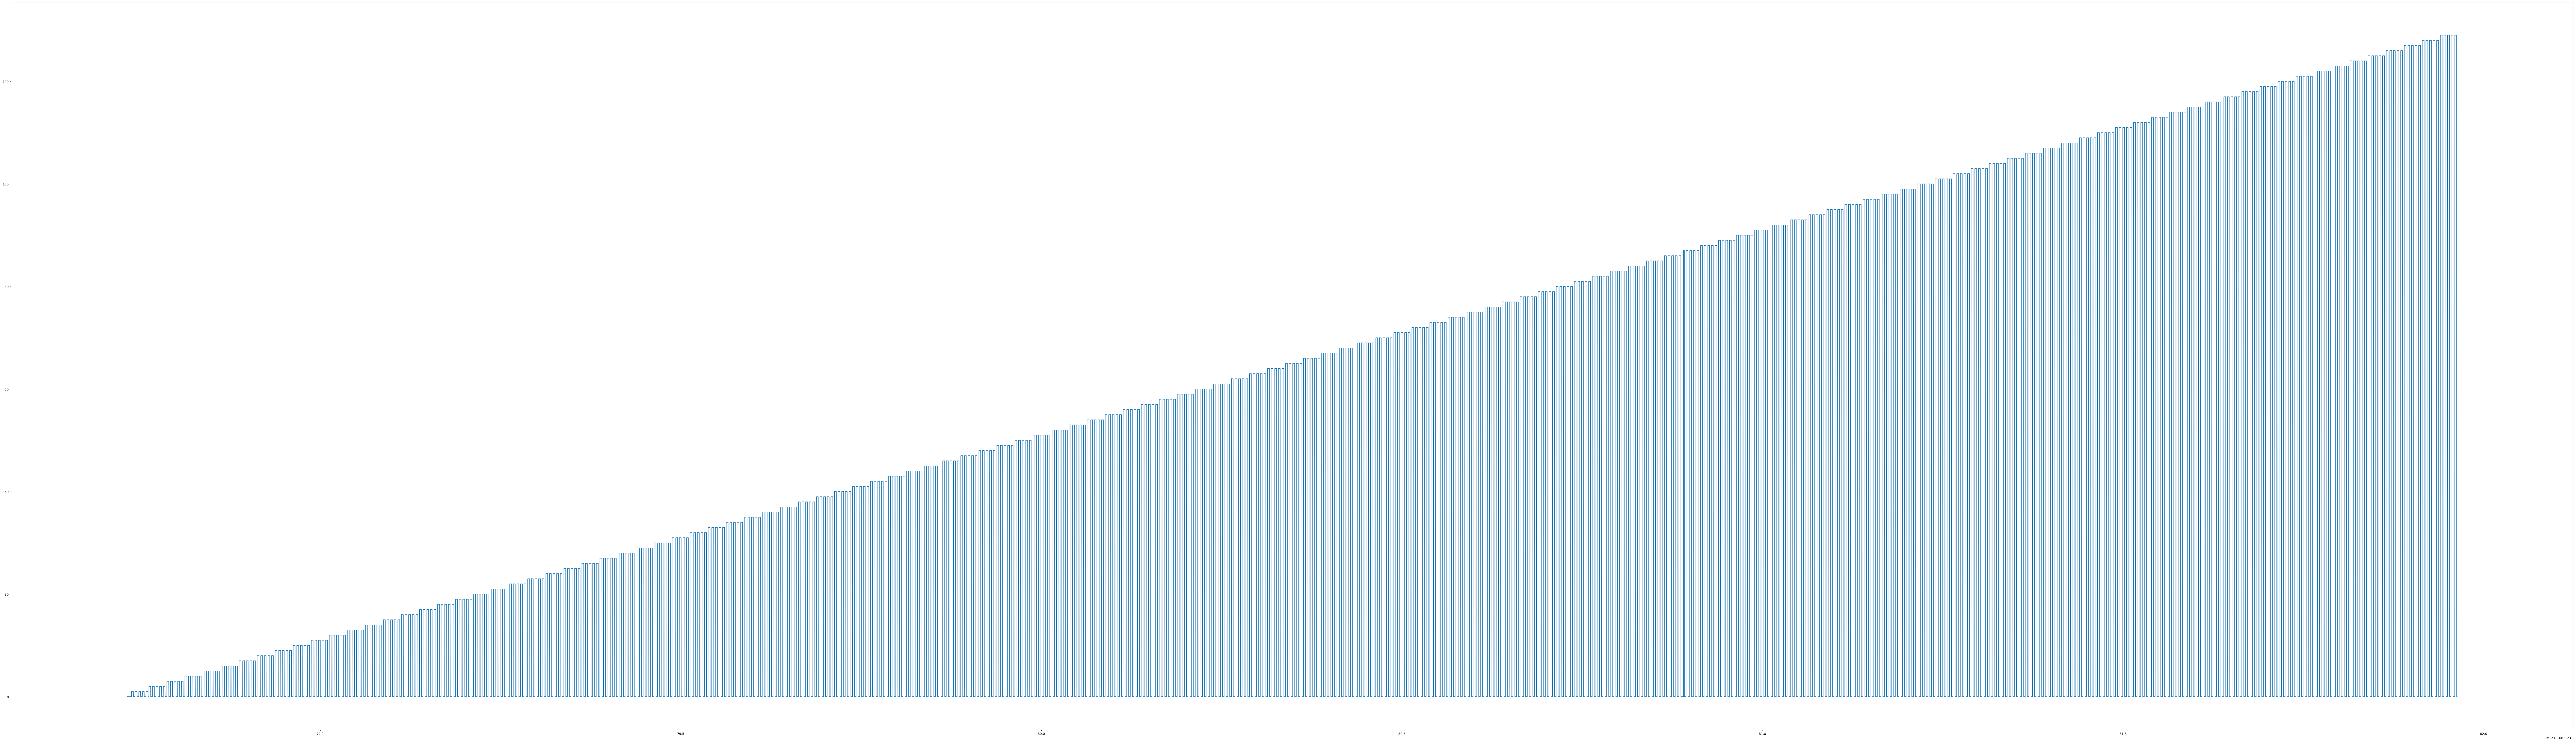

96927


In [7]:
plt.figure(figsize=(140,40))
plt.plot(contact_case_ts_int, contact_case_int)
plt.show()
print(len(contact_case_ts_int))

In [8]:
case_span = 2.66e9
find_ts_idx = lambda ts: np.searchsorted(contact_status_ts, ts)

def look_ahead_big(ts, idx_ts):
    fin_ts = ts + case_span
    fin_idx = find_ts_idx(fin_ts)
    print(fin_idx)
    if contact_status[fin_idx]:
        #look further
        more = True
        fin_idx_ = fin_idx 
        while more:
            fin_idx_ += 1
            if fin_idx_ - fin_idx > 25:
                print('warning more than 25 idx away from init_ts + case_span')
            if contact_status[fin_idx_]:
                continue
            else:
                more = False
        print(f'was before case ended by {fin_idx_ - fin_idx} indexes')
        fin_idx = fin_idx_ - 1
    else:
        #look backwards
        more = True
        fin_idx_ = fin_idx 
        while more:
            fin_idx_ -= 1
            if not contact_status[fin_idx_]:
                continue
            else:
                more = False
        print(f'was ahead case ended by {fin_idx - fin_idx} indexes')
        fin_idx = fin_idx_ + 1
        
    return contact_status_ts[fin_idx]


def find_case(ts):
    idx = find_ts_idx(ts)
    best_rot_diff = 100
    best_rot_idx = 1
    i = 1
    x, y, z = contact_angle[idx]
    for rot in list_of_rotations:
        diff_vals = np.sqrt(np.power(rot[0] - x, 2) +  np.power(rot[1] - y, 2) + np.power(rot[2] - z, 2))
        if best_rot_diff > diff_vals:
            best_rot_diff = diff_vals
            best_rot_idx = i
        i = i + 1
    return best_rot_idx


i = 0 
cases_ts = []
cases_idx = []
cases = []
while i < len(contact_status):
    if contact_status[i]:
        init_ts = contact_status_ts[i]
        fin_ts = look_ahead_big(init_ts, i)
        fin_idx = find_ts_idx(fin_ts)
        case = find_case(np.mean([init_ts, fin_ts]))
        
        cases.append(case)
        cases_ts.append([init_ts, fin_ts])
        cases_idx.append([i, fin_idx])
        print(len(cases_ts), init_ts, fin_ts, (fin_ts - init_ts)*1e-9, i, fin_idx, case, '\n')
        i = fin_idx + 1
    else:
        i += 1

416
was ahead case ended by 0 indexes
1 1662378738268597072 1662378740888466220 2.6198691480000003 282 413 1 

663
was before case ended by 3 indexes
2 1662378743228413369 1662378745928494229 2.7000808600000004 530 665 1 

885
was ahead case ended by 0 indexes
3 1662378748308327497 1662378750836139442 2.5278119450000003 784 877 1 

1136
was ahead case ended by 0 indexes
4 1662378753308512546 1662378755868273794 2.559761248 1002 1130 1 

1383
was before case ended by 1 indexes
5 1662378758251080543 1662378760928476102 2.6773955590000003 1249 1383 1 

1585
was ahead case ended by 0 indexes
6 1662378762308217783 1662378764868165283 2.5599475000000003 1452 1580 2 

1834
was ahead case ended by 0 indexes
7 1662378767268328555 1662378769948127249 2.679798694 1700 1834 2 

2084
was before case ended by 1 indexes
8 1662378772268509465 1662378774948096529 2.679587064 1950 2084 2 

2334
was before case ended by 1 indexes
9 1662378777268214868 1662378779948277480 2.680062612 2200 2334 2 

2588
wa

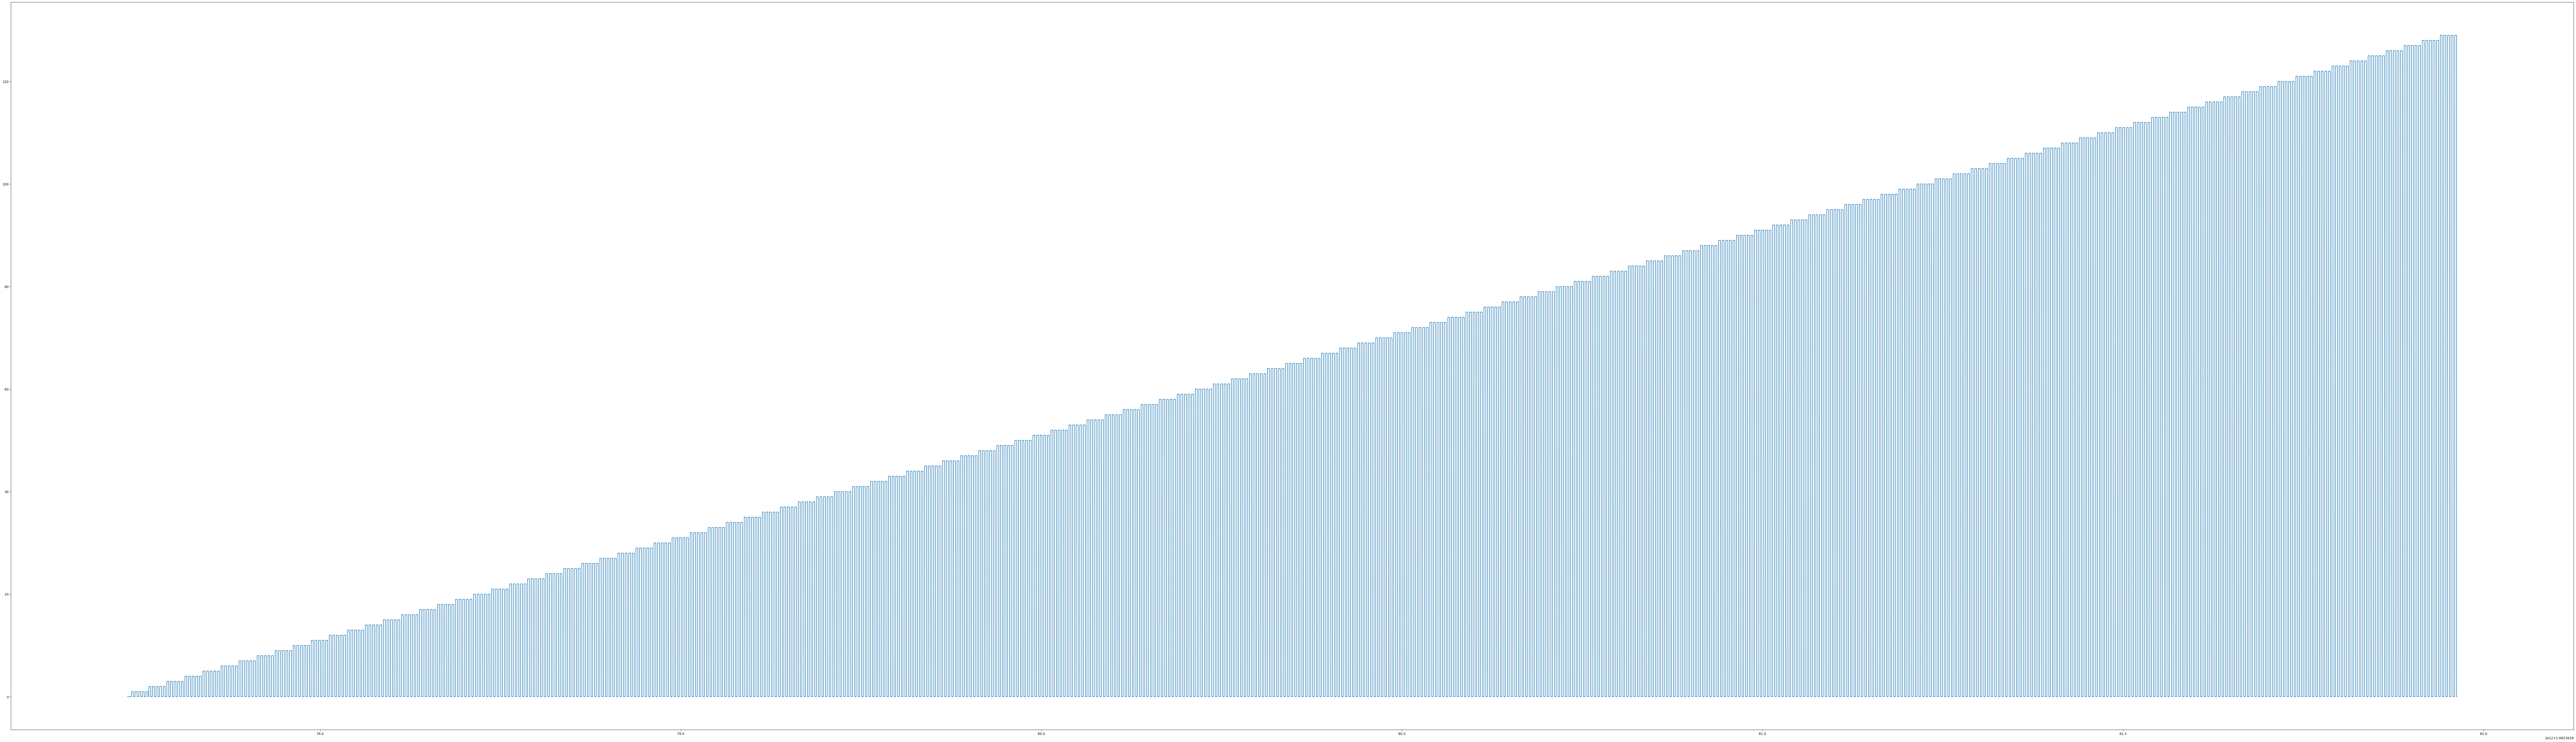

In [10]:
%matplotlib inline
contact_case_alt = np.zeros(len(contact_status))
for i, case in enumerate(cases):
    contact_case_alt[cases_idx[i][0]:cases_idx[i][1] + 1] = case
    
plt.figure(figsize=(140, 40))
plt.plot(contact_status_ts, contact_case_alt)

In [11]:
f_case = interp1d(contact_status_ts, contact_case_alt, kind='previous')
contact_case_ts_alt_int = np.arange(min(contact_status_ts), max(contact_status_ts), int(1e9/frequency))

contact_case_alt_int = f_case(contact_case_ts_alt_int)

In [12]:
def find_interp_idx(ts):
    return np.where(ts - contact_case_ts_alt_int < 0)[0][0]

In [13]:
cases_int_idx = []

for i, case_ts in enumerate(cases_ts):
    case_int_idx = list(map(find_interp_idx, case_ts))
    cases_int_idx.append(case_int_idx)

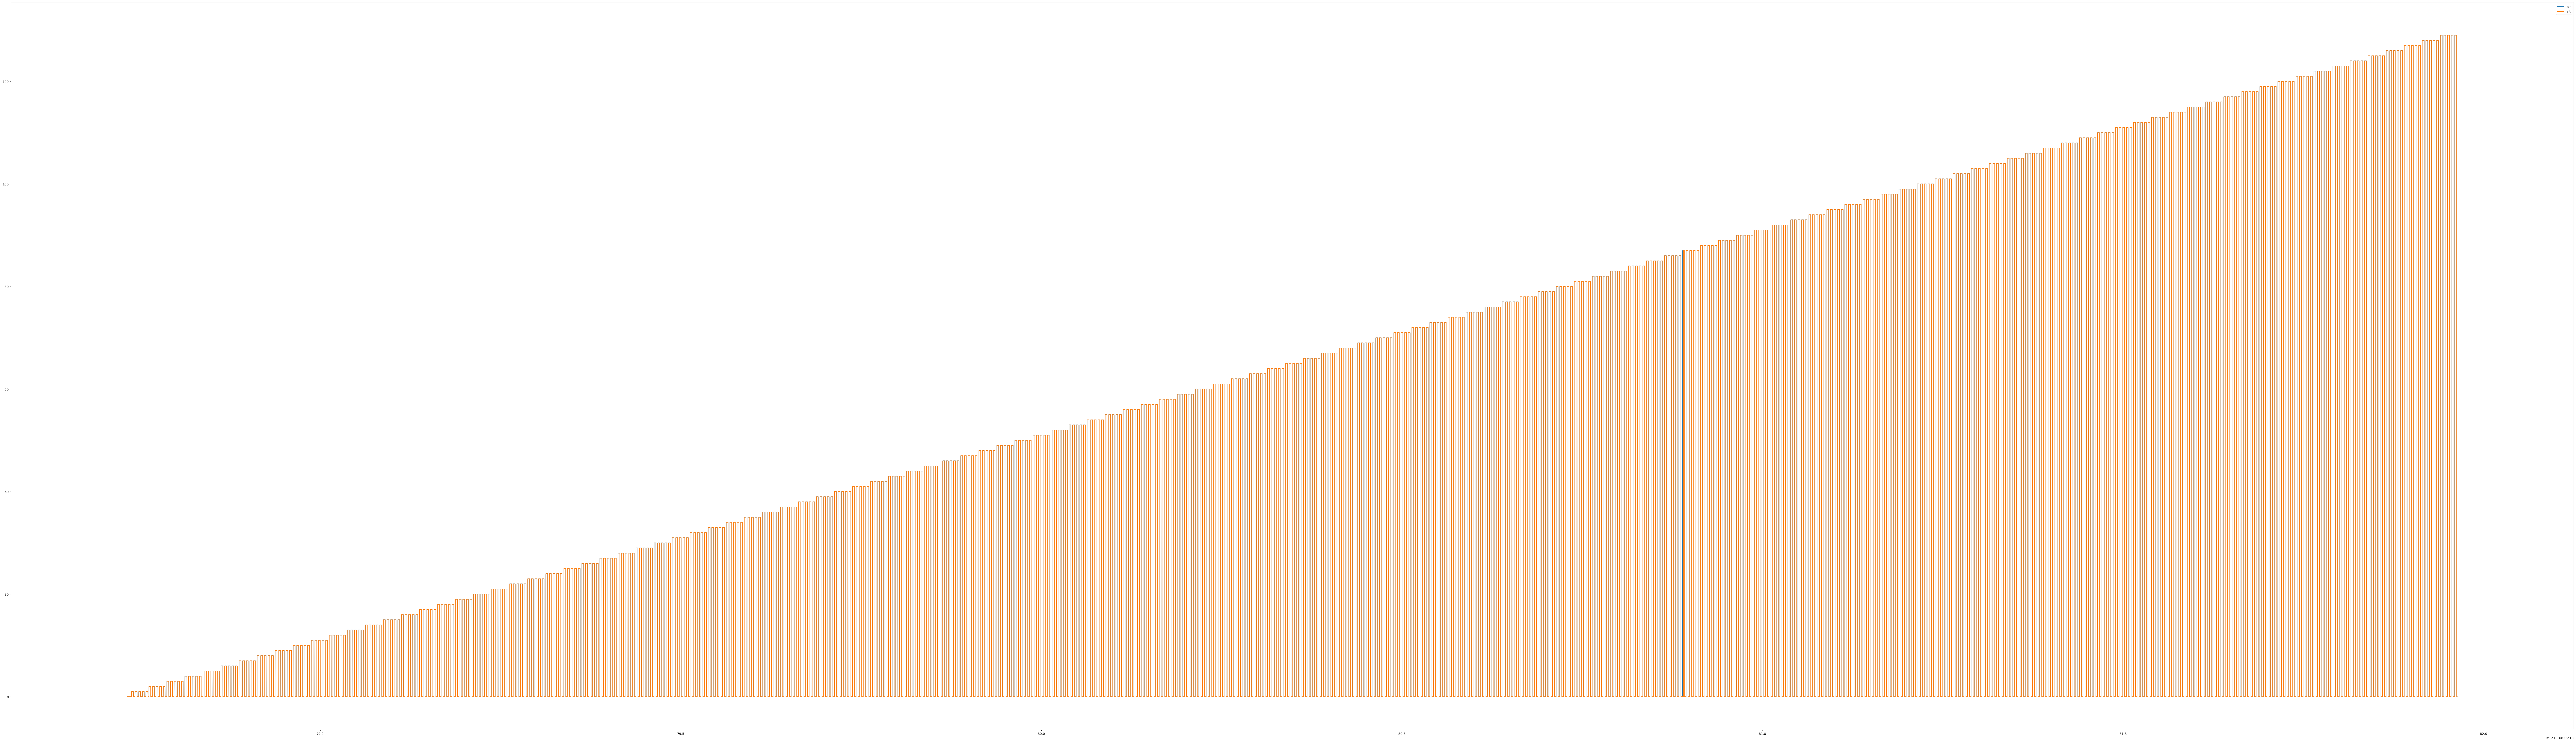

In [14]:
plt.figure(figsize=(140, 40))
plt.plot(contact_case_ts_alt_int, contact_case_alt_int, label='alt')
plt.plot(contact_case_ts_int, contact_case_int, label='int')
plt.legend()

In [15]:
ts = np.array(events)[:, 2]
ts

array([1662378732593736638, 1662378732595119638, 1662378732595269638, ...,
       1662381972813252638, 1662381972813365638, 1662381972813477638])

In [16]:
ts.shape

(11138715,)

In [17]:
hist, bin_edges = np.histogram(ts, bins=int(1e5))

In [18]:
((ts[-1] - ts[0]) / 1e5)*1e-9

0.03240219741

In [19]:
hist.shape

(100000,)

In [20]:
11138715/1e7

1.1138715

In [21]:
from scipy.signal import find_peaks
peaks_fixed_window, _ = find_peaks(hist, distance=70)
peaks_fixed_window_ts = bin_edges[peaks_fixed_window]
peaks_fixed_window.shape

(1292,)

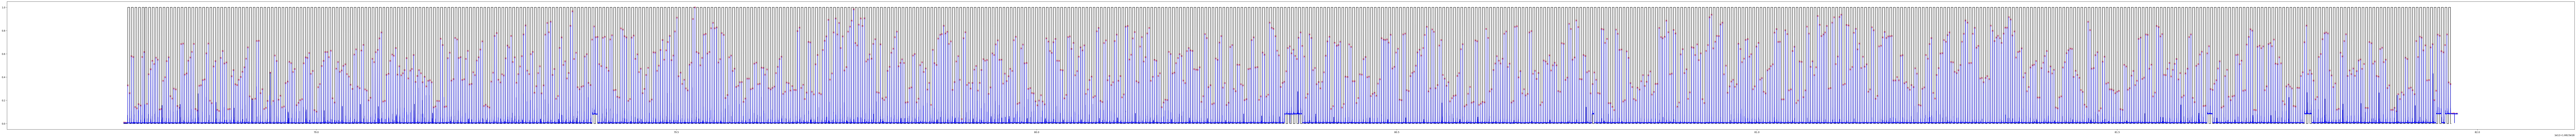

In [22]:
plt.figure(figsize=(200, 10))
plt.plot(contact_case_ts_alt_int, contact_case_alt_int > 0, color='black')
plt.plot(bin_edges[:-1], (hist - hist.min()) / (hist.max() - hist.min()), c='blue')
plt.scatter(bin_edges[:-1][peaks_fixed_window], hist[peaks_fixed_window] / hist.max(), c='r',marker='x')
#plt.scatter(bin_edges[:-1][spur], hist[spur] / hist.max(), c='r')


In [23]:
cases_ts_flat = np.array(cases_ts).reshape(-2, 1)
cases_ts_flat

array([[1662378738268597072],
       [1662378740888466220],
       [1662378743228413369],
       ...,
       [1662381957682898326],
       [1662381960025874129],
       [1662381962642994079]])

In [24]:
peaks_fixed_window_ts.reshape(-1, 1).astype(np.uint64)

array([[1662378733112171776],
       [1662378735607141120],
       [1662378738231719168],
       ...,
       [1662381965036950272],
       [1662381967369908480],
       [1662381970998954496]], dtype=uint64)

In [25]:
(cases_ts_flat-1662381965036950272)*1e-9

array([[-3.22676835e+03],
       [-3.22414848e+03],
       [-3.22180854e+03],
       ...,
       [-7.35405195e+00],
       [-5.01107614e+00],
       [-2.39395619e+00]])

In [26]:
closest = []
deltas = []
for peak_ts in peaks_fixed_window_ts:
    delta_peak = cases_ts_flat - peak_ts
    abs_delta_peak = np.abs(delta_peak)
    
    closest_case = np.argmin(abs_delta_peak)
    delta = delta_peak[closest_case][0]
    
    deltas.append(delta)
    closest.append(closest_case)
    

deltas = np.array(deltas)
abs_deltas = np.abs(deltas)

In [27]:
abs_deltas

array([5.15642522e+09, 2.66145587e+09, 3.68778240e+07, ...,
       2.39395610e+09, 4.72691430e+09, 8.35596032e+09])

In [28]:
deltas

array([ 5.15642522e+09,  2.66145587e+09,  3.68778240e+07, ...,
       -2.39395610e+09, -4.72691430e+09, -8.35596032e+09])

In [29]:
deltas

array([ 5.15642522e+09,  2.66145587e+09,  3.68778240e+07, ...,
       -2.39395610e+09, -4.72691430e+09, -8.35596032e+09])

<AxesSubplot:>

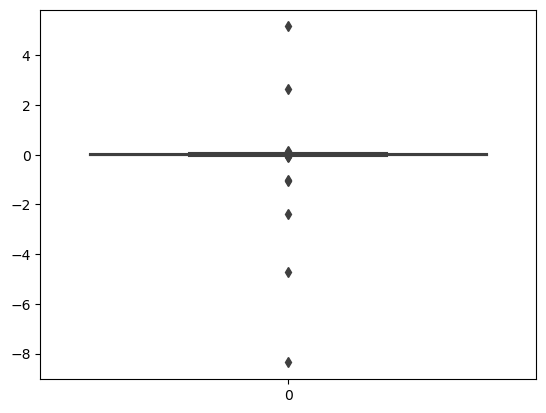

In [30]:
import seaborn as sns
sns.boxplot(deltas*1e-9)

In [31]:
np.abs(deltas)

array([5.15642522e+09, 2.66145587e+09, 3.68778240e+07, ...,
       2.39395610e+09, 4.72691430e+09, 8.35596032e+09])

<AxesSubplot:>

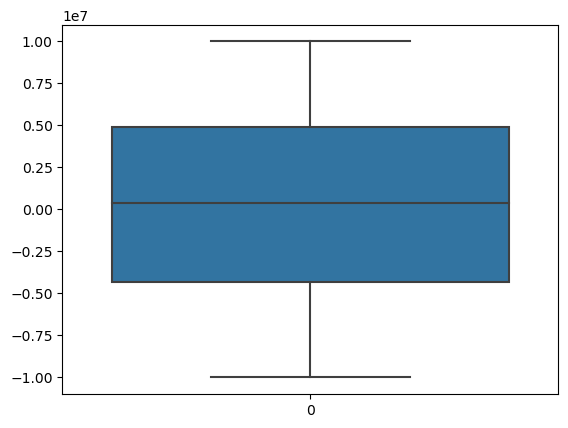

In [32]:
import seaborn as sns
sns.boxplot(deltas[np.abs(deltas) < 0.01e9])

In [33]:
sum(np.abs(deltas) > 0.1e9)

8

In [34]:
sum(deltas > 0)

666

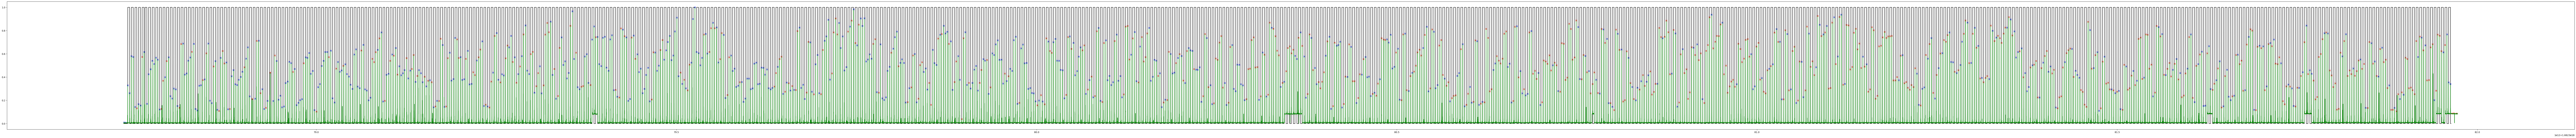

In [35]:
plt.figure(figsize=(200, 10))
plt.plot(contact_case_ts_alt_int, contact_case_alt_int > 0, color='black')
plt.plot(bin_edges[:-1], (hist - hist.min()) / (hist.max() - hist.min()), c='green')
plt.scatter(bin_edges[:-1][peaks_fixed_window][deltas >= 0], hist[peaks_fixed_window][deltas >= 0] / hist.max(), c='blue',marker='x')
plt.scatter(bin_edges[:-1][peaks_fixed_window][deltas < 0], hist[peaks_fixed_window][deltas < 0] / hist.max(), c='red',marker='x')

In [228]:
len(cases) / 5

129.0

In [ ]:
129

In [36]:
np.median(deltas)*1e-9

0.00085568

In [37]:
np.median(np.diff(ts))

27000.0

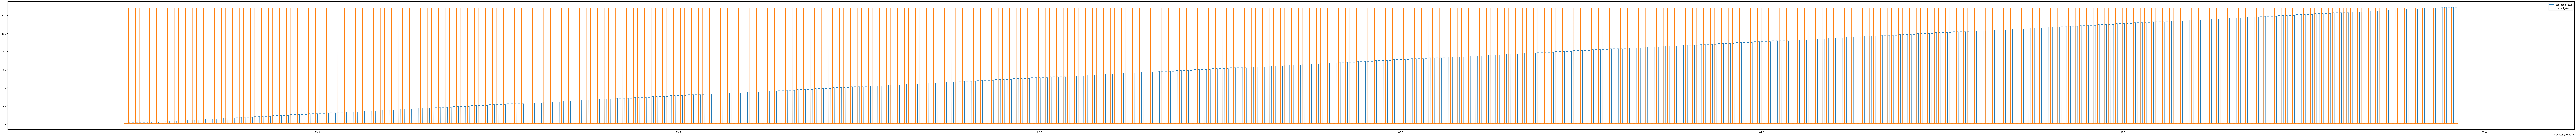

In [42]:
contact_case_diff_int = np.diff(contact_case_alt_int)
contact_case_diff_int = np.insert(contact_case_diff_int, 0, 0)
contact_rise_idx = np.where(contact_case_diff_int > 0.4)[0]

contact_rise_int = [0 for i in range(len(contact_case_int))]
for index in contact_rise_idx:
    contact_rise_int[index] = 128


plt.figure(figsize=(200, 10))
plt.plot(contact_case_ts_alt_int, contact_case_alt_int)
plt.plot(contact_case_ts_alt_int, contact_rise_int)
plt.legend(['contact_status', 'contact_rise'])
plt.show()

In [52]:
events = np.array(events)

In [170]:
def filter_events_by_time(time_of_contact, time_frame = 1e9):
    event_in_time_idx = np.where((ts > (
        time_of_contact - time_frame)) * (ts < time_of_contact))[0]
    # print(len(event_in_time_idx))
    #time_of_contact - time_frame < ts < time_of_contact
    #print(len(event_in_time_idx))
    if len(event_in_time_idx) < 5000:
        return False, []
    else:
        # print(event_in_time_idx)
        output_events = events[event_in_time_idx, :]
        return True, output_events


In [240]:
i=10
cases_int_idx[5*i:5*i+6]

[[7645, 7726],
 [7796, 7876],
 [7948, 8024],
 [8096, 8175],
 [8246, 8326],
 [8396, 8477]]

In [237]:
fig, axes = plt.subplots(13, 10, figsize=(100, 130))

for i, ax in enumerate(axes.ravel()):
    plt.sca(ax)
    cases_lab_idx = cases_int_idx[5*i:5*i+2]
    cases_lab_ts = cases_ts[5*i:5*i+2]
    
    t_ = np.array(cases_lab_ts)
    
    plt.plot(cases_lab_idx[0], 2*[1])

IndexError: list index out of range

Error in callback <function flush_figures at 0x7f3daaf505e0> (for post_execute):


KeyboardInterrupt: 

In [172]:
label_contact_case = []
i = 0
event_arrays = []
dist_from_center = lambda x, y: np.sqrt((x - 173)**2 + (y - 130)**2)
circle_rad=90

for status_index in tqdm(contact_rise_idx):
    for j in range(-7, 8):
        time_step = contact_case_ts_alt_int[status_index + j]
        detect, event_array = filter_events_by_time(time_step)
        # print(event_array)
        if detect:
            in_circle = dist_from_center(event_array[:, 0], event_array[:, 1]) < circle_rad
            event_arrays.append(event_array[in_circle, :])
            label_contact_case.append(
                contact_case_alt_int[status_index + 1])
            break
    #print()

  0%|          | 0/645 [00:00<?, ?it/s]

In [ ]:
fo

In [173]:
len(label_contact_case)

437

In [202]:
alt_arrays = []
delta_t = 0.1e9
for i, idx in enumerate(tqdm(cases_idx)):
    init_ts_idx = np.searchsorted(ts, cases_ts[i][0])
    fin_ts_idx = np.searchsorted(ts, cases_ts[i][0] + delta_t)
    
    alt_arrays.append(events[init_ts_idx:fin_ts_idx+1])

  0%|          | 0/645 [00:00<?, ?it/s]

(509, 4)


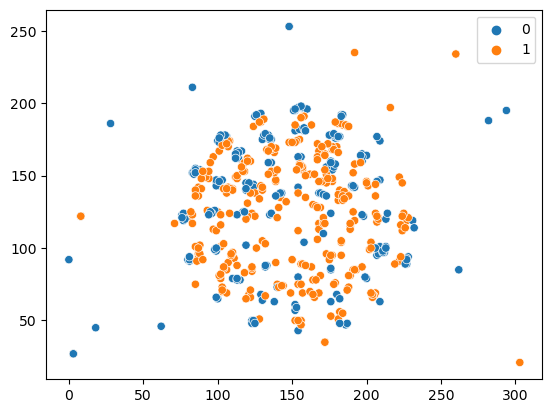

In [229]:
import seaborn as sns
def plot(ev):
    print(ev.shape)
    sns.scatterplot(x=ev[:, 0], y=ev[:, 1], hue=ev[:, 3])
    
plot(alt_arrays[223])

<AxesSubplot:>

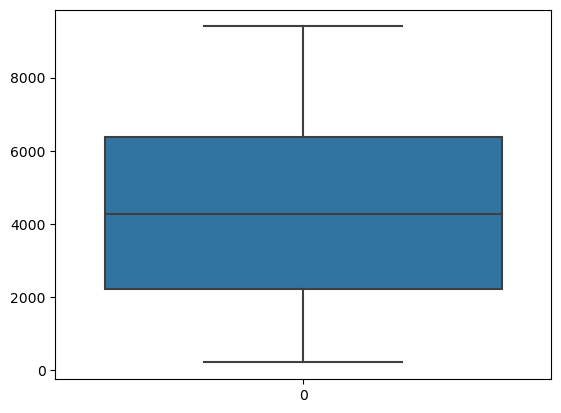

In [230]:
sns.boxplot([a.shape[0] for a in alt_arrays])

In [235]:
sum(np.array([a.shape[0] for a in alt_arrays]) < 1000)

67

In [205]:
np.sort([a.shape[0] for a in alt_arrays])

array([ 219,  226,  326,  331,  358,  368,  368,  392,  409,  417,  429,
        439,  444,  452,  453,  457,  465,  466,  503,  509,  514,  531,
        540,  555,  556,  556,  570,  576,  579,  586,  588,  588,  604,
        617,  629,  639,  683,  684,  694,  701,  704,  709,  711,  713,
        729,  732,  738,  773,  780,  796,  801,  808,  828,  833,  860,
        866,  883,  901,  904,  904,  910,  921,  926,  951,  974,  981,
        998, 1017, 1046, 1048, 1050, 1051, 1054, 1059, 1061, 1081, 1088,
       1098, 1109, 1113, 1128, 1139, 1154, 1163, 1195, 1208, 1208, 1210,
       1218, 1240, 1254, 1318, 1339, 1415, 1440, 1451, 1473, 1480, 1480,
       1492, 1499, 1516, 1537, 1538, 1542, 1551, 1576, 1579, 1584, 1591,
       1600, 1600, 1608, 1621, 1622, 1643, 1665, 1679, 1680, 1696, 1699,
       1720, 1727, 1735, 1742, 1759, 1761, 1765, 1776, 1793, 1804, 1827,
       1832, 1854, 1863, 1876, 1881, 1896, 1903, 1907, 1923, 1941, 1958,
       1981, 1987, 2008, 2012, 2021, 2022, 2030, 20

In [194]:
np.argsort([a.shape[0] for a in alt_arrays])

array([223,  14,  52, 334,  82, 430,  25, 100, 371,  38, 301,  43,  99,
        88, 305, 553,   9,   2,  85,   3, 412,  19,  47, 270,  71, 337,
       145, 216, 219, 287,  40, 437, 629, 590, 252,   5, 247,  28, 375,
       547, 119, 192, 392, 535, 254, 253, 268, 411, 621, 601, 613, 182,
       171, 239, 276, 384, 376, 314, 139, 628,  48, 188, 353, 190, 210,
       310, 136,  86, 497, 298,  35,  57, 581, 260, 341, 373, 288, 543,
       463, 367, 316,  34, 576,  23,  67, 113, 327, 155, 236, 415,  39,
       266, 433, 598, 166,  42, 154, 459, 233, 179, 607,  12, 418, 562,
       115, 640, 573, 251, 346, 570, 229, 208, 536, 185, 234, 143, 465,
       530, 345, 388, 387, 135,  64, 485, 361, 583, 187,  83,  66, 630,
       483, 501, 368,   0, 243, 320, 423, 584, 195, 184, 178, 222, 250,
       555,  13, 408,  37, 550, 631, 173, 217, 378, 183, 633, 397, 552,
       406, 444, 307, 372, 273, 244, 454, 527, 551,  62, 542, 587, 419,
       355, 125, 363, 309, 304, 634, 578, 494, 231, 461, 557, 28

<AxesSubplot:>

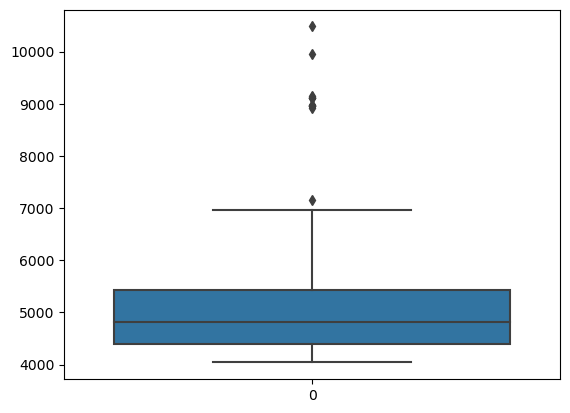

In [180]:
sns.boxplot([ev.shape[0] for ev in event_arrays])